In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('../data/migraine.csv')
pd.set_option('display.float_format', '{:0.2f}'.format)

Wyświetlenie tzw heatmapy czy macierzy przedstawiającej stopień korelacji pomiędzy cechami.

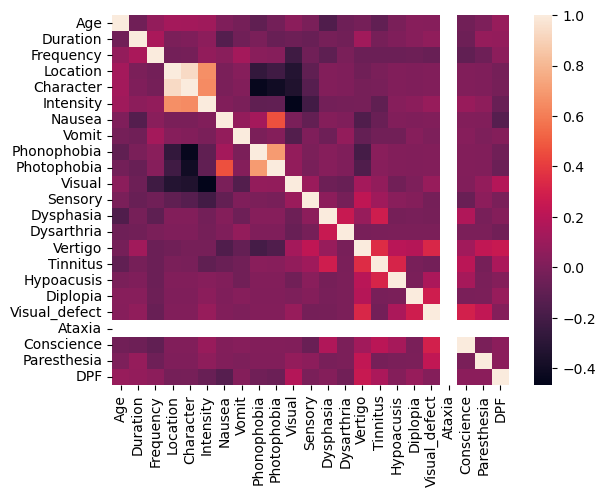

In [3]:
X = df.iloc[:, :-1]

corr = X.corr()
_ = sns.heatmap(corr)

Jak widać z powyzszego wykresu Ataxia nie wystąpiła ani razu w całym zbiorze. Mozemy ją więc usunąć.

In [4]:
X = X.drop(columns="Ataxia")

...oraz ponownie wyświetlić heatmapę korelacji.

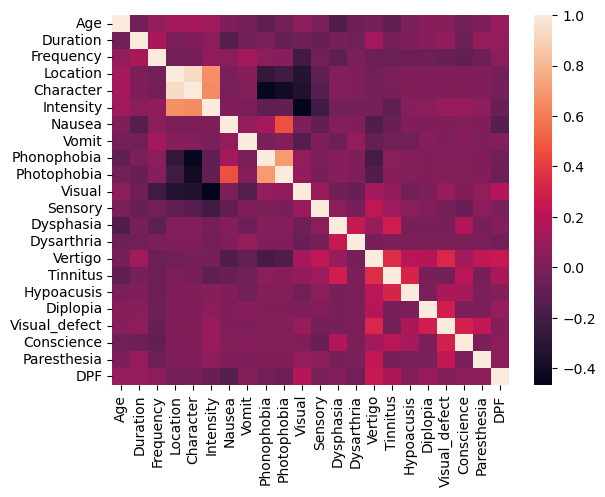

In [5]:
corr = X.corr()
_ = sns.heatmap(corr)

Normalizacja przy pomocy MinMaxScalera.

In [6]:
from sklearn.preprocessing import MinMaxScaler

#X = df.iloc[:, :-1]
y = df.iloc[:, -1:]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Klasyfikacja metodami kNN i SVC. Dla kNN liczba analizowanych "sąsiadów" wynosiła 3 zaś dla SVC przyjmujemy liniowy charakter hiperpłaszczyzny.

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

kfold = StratifiedKFold(n_splits = 5)

names = [
    'kNN',
    'SVC'
]

classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    SVC(kernel = 'linear')
]

Definicja algorytmu selekcji cech SKB (czyli Select k Best), wybór k dzięsęciu najlepszych i wyświetlenie nowych nazw cech:

In [8]:
from sklearn.feature_selection import SelectKBest, chi2

skb = SelectKBest(chi2, k = 10)
X2 = skb.fit_transform(X, y)

skb.get_feature_names_out()

array(['x10', 'x12', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21'], dtype=object)

Definicja selektora cech RFE (dla klasyfikatora SVC i redukcji do 10 cech):

In [9]:
from sklearn.feature_selection import RFE

svc = SVC(kernel = 'linear')

rfe = RFE(estimator = svc, n_features_to_select = 10, step = 1)
X3 = rfe.fit_transform(X, y.values.ravel())

Definicja ekstraktora cech PCA (ekstrakcja do 4 cech).

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)
X4 = pca.fit_transform(X)

In [12]:
print(pca.explained_variance_ratio_)

[0.20759099 0.17600177 0.12158708 0.1023161 ]


Porównanie wyników dla wszystkich kombinacji klasyfikatrów oraz metod i ekstrakcji (z tym ze RFE zdefiniowane było dla SVC więc wynik RFE dla kNN wydaję się być mocno dyskusyjny):

In [13]:
for name, classifier in zip(names, classifiers):
    score = cross_val_score(classifier, X, y.values.ravel(), cv = kfold)
    score2 = cross_val_score(classifier, X2, y.values.ravel(), cv = kfold)
    score3 = cross_val_score(classifier, X3, y.values.ravel(), cv = kfold)
    score4 = cross_val_score(classifier, X4, y.values.ravel(), cv = kfold)
    print('Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora {} wyniosła:\t\t\t{}'.format(name, score.mean()))
    print('Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora {} i metody SKB wyniosła:\t{}'.format(name, score2.mean()))
    print('Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora {} i metody RFE wyniosła:\t{}'.format(name, score3.mean()))
    print('Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora {} i metody PCA:\t\t{}'.format(name, score4.mean()))

Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora kNN wyniosła:			0.8024999999999999
Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora kNN i metody SKB wyniosła:	0.7825
Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora kNN i metody RFE wyniosła:	0.865
Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora kNN i metody PCA:		0.7
Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora SVC wyniosła:			0.8825
Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora SVC i metody SKB wyniosła:	0.8
Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora SVC i metody RFE wyniosła:	0.8825
Średnia dokładność klasyfikacji z wykorzystaniem klasyfikatora SVC i metody PCA:		0.735


Co interesujące to właśnie dyskusyjny eksperyment klasyfikacji KNN z selekcją RFE poprawił wynik dla kNN o 8 punktów procentowych a np. SKB pogorszył go o dwa. W przypadku klasyfikatora SVC w/w metody albo nie zmieniły wyniku (RFE) albo pogorszyły wynik od 8-10 punktów procentowych.